# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import f1_score
import torch
from datasets import DatasetDict
from textaugment import EDA
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelForMaskedLM

np.random.seed(42) 

c:\Python3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_PATH = "data"

def load_data(path=DATA_PATH):
    def get_path(set_type, is_args):
        return os.path.join(DATA_PATH, set_type, ("arguments" if is_args else "labels") + "-" + set_type + ".tsv")
    
    data = {}
    
    for set_type in ["test", "training", "validation"]:
        args = pd.read_csv(get_path(set_type, True), sep="\t")
        
        labels = pd.read_csv(get_path(set_type, False), sep="\t")
        labels = labels.drop("Argument ID", axis=1)
        args["Labels"] = [x for x in labels.to_numpy()]
        
        data[set_type] = args
        print(f"Set:{set_type.title()} - Size:{args.shape[0]}")
        
    classes = list(labels.columns)
    
    return data, classes

data, classes = load_data()
data["training"].head()
print("\nClasses:", classes)

Set:Test - Size:1576
Set:Training - Size:5393
Set:Validation - Size:1896

Classes: ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']


(5393, 5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1259 1920
(4817, 5)
(6076, 5)


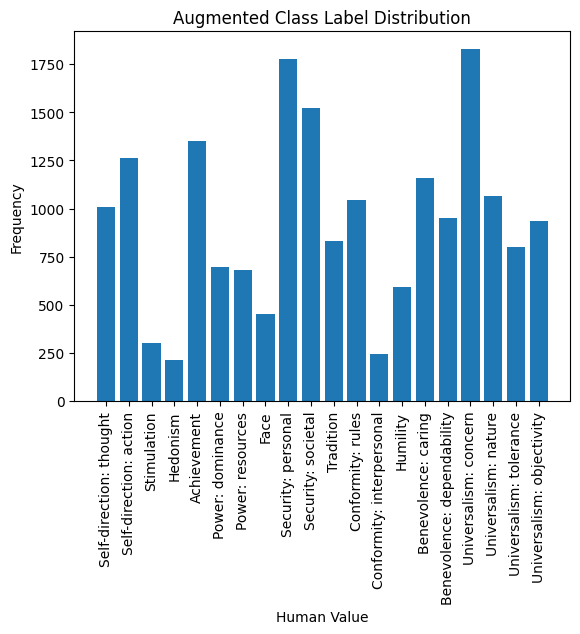

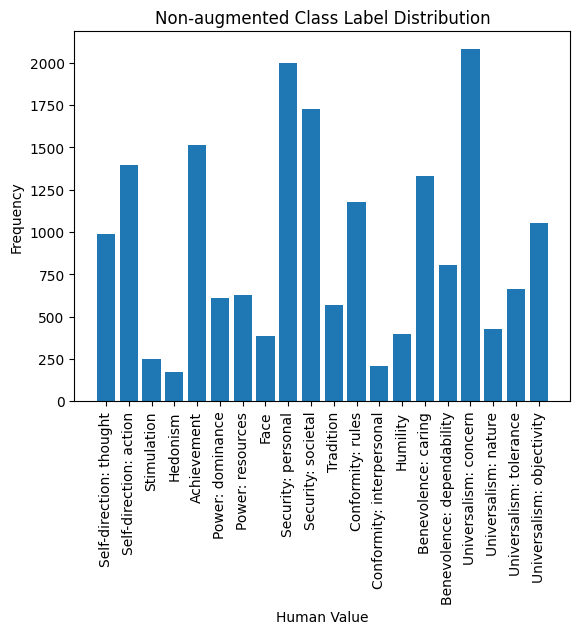

In [4]:
from itertools import chain
from collections import Counter
import random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def fix_class_imbalance(data, eda=False):
    russian_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_ru_augm.npy'))
    german_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_de_augm.npy'))

    data_counts = data["training"]['Labels'].sum(axis=0)
    mean_freq = np.mean(data_counts)
    min_classes = np.where(data_counts < mean_freq)[0]
    max_classes = np.where(data_counts >= mean_freq)[0]
    
    data["training_aug"] = data["training"].copy()
    print(data["training_aug"].shape)

    
    rows_to_remove = []
    rows_to_add = []
    
    for row_idx, row_labels in enumerate(data["training"]['Labels']):
        # if np.sum(np.asarray(row_labels)) == 1:
        #     class_idx = np.where(row_labels==1)
        if not np.intersect1d( np.where(row_labels==1), max_classes).any():
            premise = data["training"].iloc[row_idx]["Premise"]
            if premise.lower() != russian_aug[row_idx].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = russian_aug[row_idx]
                rows_to_add.append(new_row)
            
            if premise.lower() != german_aug[row_idx].lower() and german_aug[row_idx].lower() != new_row["Premise"].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = german_aug[row_idx]
                rows_to_add.append(new_row)
            
            if eda:
                eda = EDA()
                prem_size = len(premise)
                aug_premises = [eda.synonym_replacement(premise, int(prem_size*0.3)), 
                                eda.random_swap(premise,int(prem_size*0.2)),
                                eda.random_insertion(premise, int(prem_size*0.1)),
                                eda.random_deletion(premise, p=0.2)]
                for aug_prem in aug_premises:
                    new_row = data["training"].iloc[row_idx].copy()
                    new_row["Premise"] = aug_prem
                    rows_to_add.append(new_row)
        elif not np.intersect1d( np.where(row_labels==1), min_classes).any():
            rows_to_remove.append(row_idx)

    print(len(rows_to_add), len(rows_to_remove))
    rows_to_remove = random.sample(rows_to_remove, int(len(rows_to_remove)*0.3))
    data["training_aug"] = data["training_aug"].drop(data["training_aug"].index[rows_to_remove])
    print(data["training_aug"].shape)

    data["training_aug"] = pd.concat([pd.DataFrame(rows_to_add), data["training_aug"]]).reset_index(drop=True)


fix_class_imbalance(data, eda=True)
print(data["training_aug"].shape)

data_counts_new = data["training_aug"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Augmented Class Label Distribution")
plt.show()

data_counts_new = data["training"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Non-augmented Class Label Distribution")
plt.show()
    

918.5
[ 2  3  5  6  7 10 12 13 15 17 18]
(5393, 5)
(8854, 5)


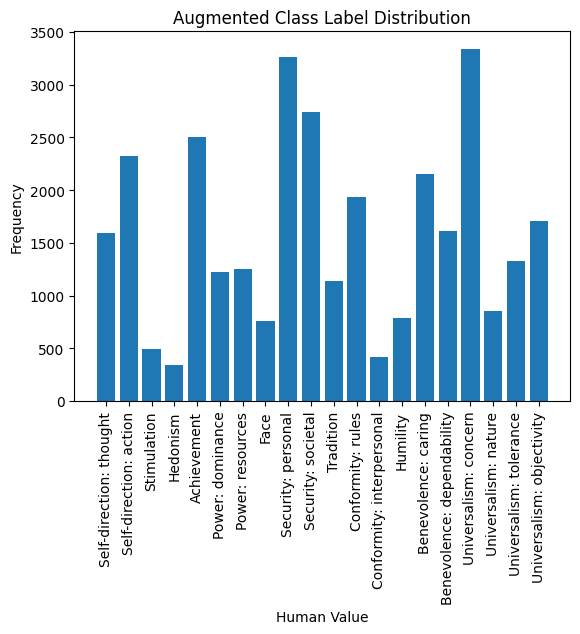

In [5]:
def add_augmented_data(data):
    russian_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_ru_augm.npy'))
    german_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_de_augm.npy'))

    data_counts = data["training"]['Labels'].sum(axis=0)
    mean_freq = np.mean(data_counts)
    min_classes = np.where(data_counts < mean_freq)[0]
    print(mean_freq)
    print(min_classes)

    data["training_aug"] = data["training"].copy()
    print(data["training_aug"].shape)

    rows_to_add = []

    for row_idx, row_labels in enumerate(data["training"]['Labels']):
        for flagged_classes in np.where(row_labels==1):
            if np.intersect1d(flagged_classes, min_classes).any():

                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = german_aug[row_idx] if np.random.random() > 0.5 else russian_aug[row_idx]
                rows_to_add.append(new_row)

    data["training_aug"] = pd.concat([pd.DataFrame(rows_to_add), data["training_aug"]]).reset_index(drop=True)

add_augmented_data(data)
print(data["training_aug"].shape)

data_counts_new = data["training_aug"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Augmented Class Label Distribution")
plt.show()

# Pre-processing

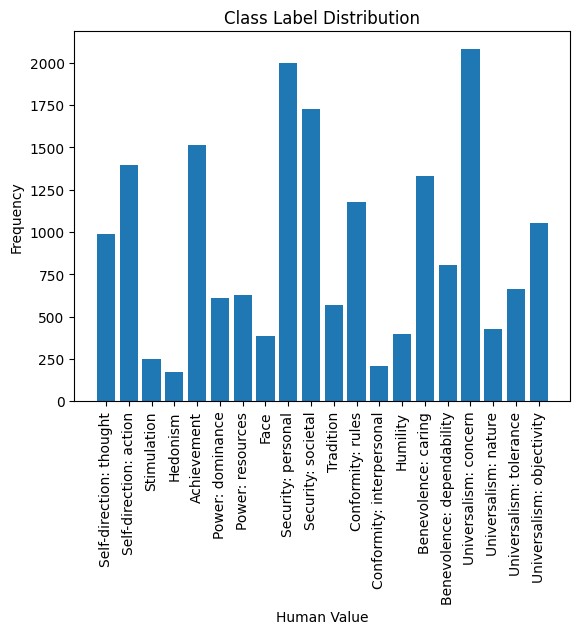

In [6]:
data_counts = data["training"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Class Label Distribution")
plt.show()

# Model

In [7]:
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True):
    """Compute accuracy of predictions"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    return ((y_pred > thresh) == y_true.bool()).float().mean().item()


def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    """Compute label-wise and averaged F1-scores"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)

    return f1_scores


def compute_metrics(eval_pred, value_classes):
    """Custom metric calculation function for MultiLabelTrainer"""
    predictions, labels = eval_pred
    f1scores = f1_score_per_label(predictions, labels, value_classes)
    return {'accuracy_thresh': accuracy_thresh(predictions, labels), 'f1-score': f1scores,
            'macro-avg-f1score': f1scores['avg-f1-score']}

In [8]:
class MultiLabelTrainer(Trainer):
    """
        A transformers `Trainer` with custom loss computation

        Methods
        -------
        compute_loss(model, inputs, return_outputs=False):
            Overrides loss computation from Trainer class
        """
    def compute_loss(self, model, inputs, return_outputs=False):
        """Custom loss computation"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [9]:
print(data.keys())
data["training_aug"]

dict_keys(['test', 'training', 'validation', 'training_aug'])


,Argument ID,Conclusion,Stance,Premise,Labels
0,A01006,We should end the use of economic sanctions,against,Sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01010,We should prohibit school prayer,against,it should be allowed if the student wants to p...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,A01011,We should abolish the three-strikes laws,in favor of,Three strike laws can lead to young people bei...,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
3,A01015,We should adopt an austerity regime,in favor of,We should introduce a savings system because i...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
4,A01016,We should adopt gender-neutral language,against,A gender neutral language is another way to pl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
...,...,...,...,...,...
8849,E08016,The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
8850,E08017,Food whose production has been subsidized with...,in favor of,The subsidies were originally intended to ensu...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
8851,E08018,Food whose production has been subsidized with...,in favor of,These products come mainly from large enterpri...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8852,E08019,Food whose production has been subsidized with...,in favor of,Subsidies often make farmers in recipient coun...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

label_values = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]


def encode(str_input):
    return tokenizer(str_input, truncation=True)

train_data = data["training"]["Premise"]
train_data = train_data.map(encode)
for i, x in enumerate(train_data):
    x["labels"] = data["training"]["Labels"][i]

val_data = data["validation"]["Premise"]
val_data = val_data.map(encode)
for i, x in enumerate(val_data):
    x["labels"] = data["validation"]["Labels"][i]
    
test_data = data["test"]["Premise"]
test_data = test_data.map(encode)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=len(classes))
    
if torch.cuda.is_available():
    model = model.to('cuda')

training_args = TrainingArguments(
    output_dir="models",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='macro-avg-f1score',
    evaluation_strategy="steps",
)

print(val_data[0])

trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_values),
)

trainer.train()
model.save_pretrained("test")


In [11]:
def test(data, classes, model_name, tok_name):
    model_eval = AutoModelForSequenceClassification.from_pretrained(tok_name, num_labels=len(classes)) # tok_name was model_name before but that didn't run for me
    tokenizer_eval = AutoTokenizer.from_pretrained(tok_name)
    trainer_eval = MultiLabelTrainer(model_eval, tokenizer=tokenizer_eval)

    def encode(str_input):
        return tokenizer_eval(str_input, truncation=True)

    eval_data = data["Premise"].map(encode)

    pred = trainer_eval.predict(eval_data).predictions
    
    true = np.array([x for x in data["Labels"]])
    f1_scores = f1_score_per_label(pred, true, classes)
    
    return f1_scores
    
f1_scores_bert = test(data["test"], classes, "bert_paper_model", "bert-base-uncased")
f1_scores_distilbert = test(data["test"], classes, "own-distilbert-model", "distilbert-base-uncased")
f1_scores_roberta = test(data["test"], classes, "own-roberta-model", "roberta-base")

c:\Python3.11\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\stefa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weigh

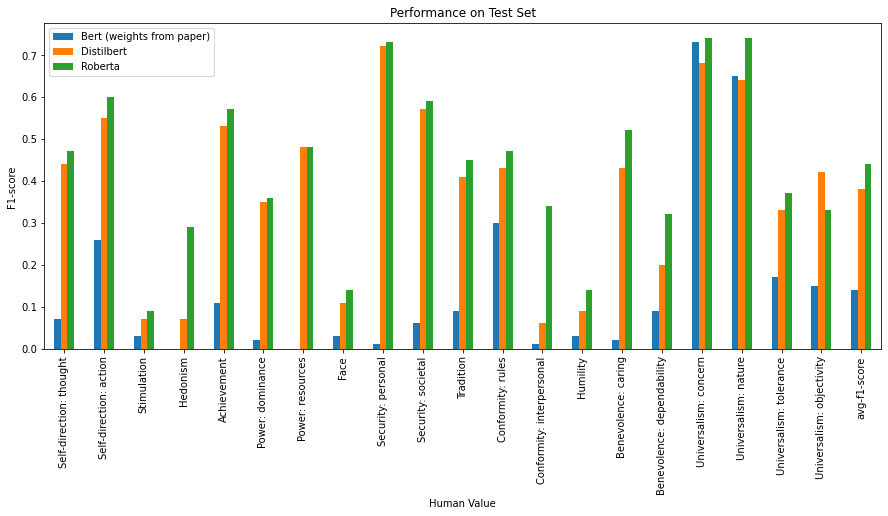

In [ ]:
df = pd.DataFrame({"Human Value": f1_scores_bert.keys(),
                   "Bert (weights from paper)": f1_scores_bert.values(), 
                   "Distilbert": f1_scores_distilbert.values(),
                   "Roberta": f1_scores_roberta.values()})

df.head()
plt.rcParams["figure.figsize"] = (15,6)
df.plot(x="Human Value", y=["Bert (weights from paper)", "Distilbert", "Roberta"], kind="bar")
plt.title("Performance on Test Set")
plt.ylabel("F1-score")
plt.show()

In [ ]:
# df = pd.DataFrame({"Human Value": f1_scores_bert.keys(),
#                    "Bert (weights from paper)": f1_scores_bert.values(), 
#                    "Distilbert": f1_scores_distilbert.values(),
#                    "Roberta": f1_scores_roberta.values()})

# df.head()
# plt.rcParams["figure.figsize"] = (15,6)
# df.plot(x="Human Value", y=["Bert (weights from paper)", "Distilbert", "Roberta"], kind="bar")
# plt.title("Performance on Validation Set")
# plt.ylabel("F1-score")
# plt.show()

# MLM model

In [12]:
def labels_to_text(labels_string):
    return [label_values_single[i] for i in range(len(label_values_single)) if labels_string[i] == 1]

def create_argument_1(row):
    conclusion = row['Conclusion'].rstrip('.').lower()
    premise = row['Premise'].rstrip('.').lower()
    stance = row['Stance']
    argument = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value {', '.join(row['Labels_text'])} supports this argument."
    argument_with_mask = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value [MASK] supports this argument."
    return argument, argument_with_mask

def create_argument_2(row):
    premise = row['Premise'].rstrip('.').lower()
    argument = f"The premise {premise} resonates with the human value of {', '.join(row['Labels_text'])}."
    argument_with_mask = f"The premise {premise} resonates with the human value of [MASK]."
    return argument, argument_with_mask

label_values_single = ["thought", "action", "Stimulation", "Hedonism", "Achievement", "dominance", "resources", "Face", "personal", "societal", "Tradition", "rules", "interpersonal", "Humility", "caring", "dependability", "concern", "nature", "tolerance", "objectivity"]

for split in data.keys():
    data[split]['Labels_text'] = data[split]['Labels'].map(lambda x: labels_to_text(x))
    data[split]['Argument_1'], data[split]['Argument_1_mask'] = zip(*data[split].apply(create_argument_1, axis=1))
    data[split]['Argument_2'], data[split]['Argument_2_mask'] = zip(*data[split].apply(create_argument_2, axis=1))

data["test"].head()


,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...


In [13]:
print(data["test"]["Argument_1_mask"][0]) # full argument
print(data["test"]["Argument_2_mask"][0]) # only premise

The premise affirmative action helps with employment equity is against the conclusion that we should end affirmative action. The human value [MASK] supports this argument.
The premise affirmative action helps with employment equity resonates with the human value of [MASK].


In [ ]:
# data_exploded = data.copy()

# for split in data.keys():
#     data_exploded[split] = data[split].explode('Labels_text')
#     data_exploded[split] = data_exploded[split].reset_index(drop=True)

# data_exploded['training'].head()

In [14]:
model_checkpoint = "distilbert-base-uncased"
distilbert_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def get_predictions(column):

    predictions = []

    for text in data["test"][column]:

        inputs = distilbert_tokenizer(text, return_tensors="pt")
        token_logits = distilbert_model(**inputs).logits
        # Find the location of [MASK] and extract its logits
        mask_token_index = torch.where(inputs["input_ids"] == distilbert_tokenizer.mask_token_id)[1]
        mask_token_logits = token_logits[0, mask_token_index, :]
        # Pick the [MASK] candidates with the highest logits
        top_tokens = torch.topk(mask_token_logits, 10, dim=1).indices[0].tolist()

        pred = []
        for token in top_tokens:
            pred.append(distilbert_tokenizer.decode([token]))

        predictions.append(pred)

    return predictions


predictions_1 = get_predictions("Argument_1_mask")
predictions_2 = get_predictions("Argument_2_mask")

# Map prediction to classes using word2vec

In [15]:
from gensim import models
import numpy as np
from gensim.models import KeyedVectors

word2vec_path = "C:\Work\RUG\Master\Language technology project\GoogleNews-vectors-negative300.bin" # get this from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [16]:
def map_words_to_classes(candidate_words, classes, num_classes):
    mappings = []

    for candidate_word in candidate_words:
        similarity_scores = []
        for class_word in classes:
            if candidate_word in model and class_word in model:
                similarity = model.similarity(candidate_word, class_word)
                similarity_scores.append(similarity)

    similarity_scores = np.array(similarity_scores)
    classes = np.array(classes)
    top_indices = np.argsort(similarity_scores)[-num_classes:]
    top_classes = [classes[i] for i in top_indices]
    # print(top_classes)
    mappings.append(top_classes)

    return mappings

labels = list(data["test"]["Labels_text"])

all_mappings_1 = []
for pred, lab in zip(predictions_1, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_1.append(word_mappings[0])

all_mappings_2 = []
for pred, lab in zip(predictions_2, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_2.append(word_mappings[0])

In [17]:
data["test"]["Prediction_1"] = all_mappings_1
data["test"]["Prediction_2"] = all_mappings_2
data["test"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_1,Prediction_2
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,"[tolerance, societal, resources, rules]","[Humility, dependability, Achievement, dominance]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,"[nature, societal, dependability, rules]","[tolerance, societal, Hedonism, interpersonal]"
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,"[dependability, concern, tolerance, societal]","[Achievement, thought, personal, caring]"
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,[societal],[dominance]
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,"[nature, tolerance, societal, resources, rules]","[interpersonal, personal, caring, resources, s..."


In [18]:
def one_hot_encode(words):
    encoding = np.zeros(len(label_values_single), dtype=int)
    for word in words:
        if word in label_values_single:
            encoding[label_values_single.index(word)] = 1
    return encoding

data["test"]['Pred_1_one_hot'] = data["test"]['Prediction_1'].apply(lambda x: one_hot_encode(x))
data["test"]['Pred_2_one_hot'] = data["test"]['Prediction_2'].apply(lambda x: one_hot_encode(x))

data["test"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_1,Prediction_2,Pred_1_one_hot,Pred_2_one_hot
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,"[tolerance, societal, resources, rules]","[Humility, dependability, Achievement, dominance]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,"[nature, societal, dependability, rules]","[tolerance, societal, Hedonism, interpersonal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,"[dependability, concern, tolerance, societal]","[Achievement, thought, personal, caring]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,[societal],[dominance],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,"[nature, tolerance, societal, resources, rules]","[interpersonal, personal, caring, resources, s...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, ..."


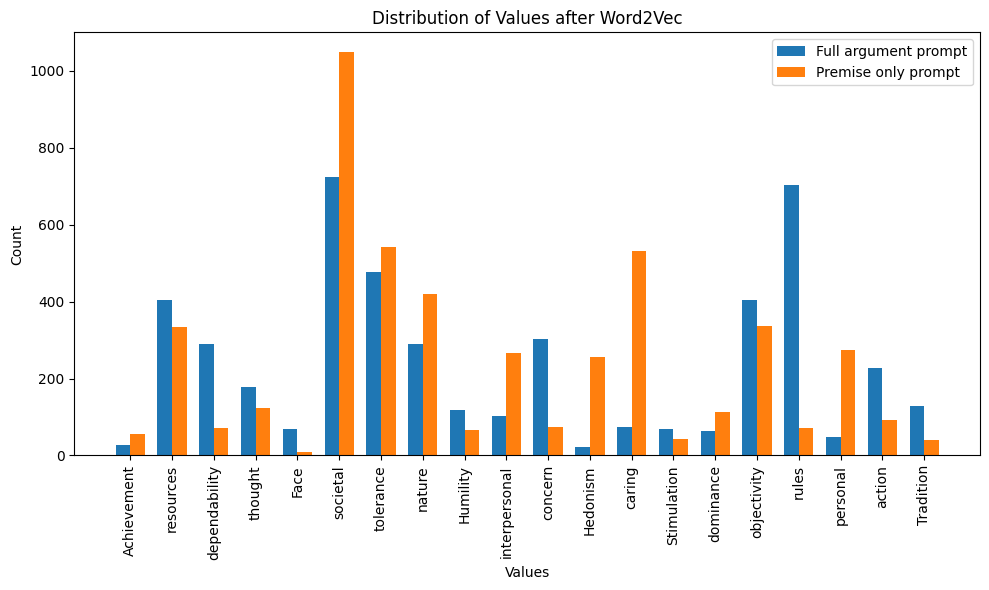

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

flat_strings1 = [item for sublist in data["test"]['Prediction_1'] for item in sublist]
flat_strings2 = [item for sublist in data["test"]['Prediction_2'] for item in sublist]

string_counts1 = pd.Series(flat_strings1).value_counts()
string_counts2 = pd.Series(flat_strings2).value_counts()

unique_strings = list(set(string_counts1.index) | set(string_counts2.index))

string_counts1 = string_counts1.reindex(unique_strings, fill_value=0)
string_counts2 = string_counts2.reindex(unique_strings, fill_value=0)

x = np.arange(len(unique_strings))

width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, string_counts1, width, label='Full argument prompt')
rects2 = ax.bar(x + width/2, string_counts2, width, label='Premise only prompt')

ax.set_xlabel('Values')
ax.set_ylabel('Count')
ax.set_title('Distribution of Values after Word2Vec')
ax.set_xticks(x)
ax.set_xticklabels(unique_strings, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
def one_hot_encode(words):
    encoding = np.zeros(len(label_values_single), dtype=int)
    for word in words:
        if word in label_values_single:
            encoding[label_values_single.index(word)] = 1
    return encoding


def test_mlm(data, classes, type=1):

    data[f"Pred_{type}_one_hot"] = data[f'Prediction_{type}'].apply(lambda x: one_hot_encode(x))

    pred = np.array([x for x in data[f"Pred_{type}_one_hot"]]) 
    
    true = np.array([x for x in data["Labels"]])
    f1_scores = f1_score_per_label(pred, true, classes)
    
    return f1_scores
    
# f1_scores_bert = test(data["test"], classes, "bert_paper_model", "bert-base-uncased")
# f1_scores_distilbert = test(data["test"], classes, "own-distilbert-model", "distilbert-base-uncased")
# f1_scores_roberta = test(data["test"], classes, "own-roberta-model", "roberta-base")
f1_scores_mlm_1 = test_mlm(data["test"], classes, type=1)
f1_scores_mlm_2 = test_mlm(data["test"], classes, type=2)

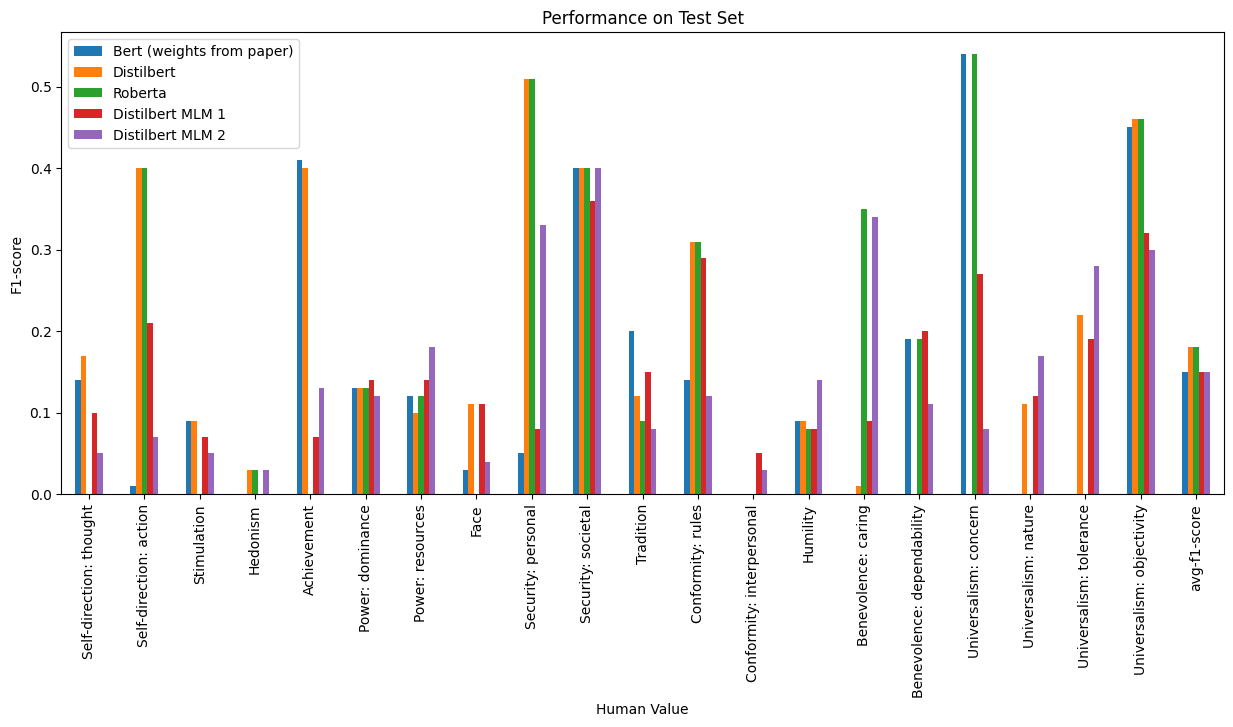

In [21]:
df = pd.DataFrame({ "Human Value": f1_scores_mlm_1.keys(),
                   "Bert (weights from paper)": f1_scores_bert.values(), 
                   "Distilbert": f1_scores_distilbert.values(),
                   "Roberta": f1_scores_roberta.values(),
                   "Distilbert MLM 1": f1_scores_mlm_1.values(),
                   "Distilbert MLM 2": f1_scores_mlm_2.values()})

df.head()
plt.rcParams["figure.figsize"] = (15,6)
df.plot(x="Human Value", y=["Bert (weights from paper)", "Distilbert", "Roberta", "Distilbert MLM 1", "Distilbert MLM 2"], kind="bar")
plt.title("Performance on Test Set")
plt.ylabel("F1-score")
plt.show()